Prix actuel AAPL: 234.40


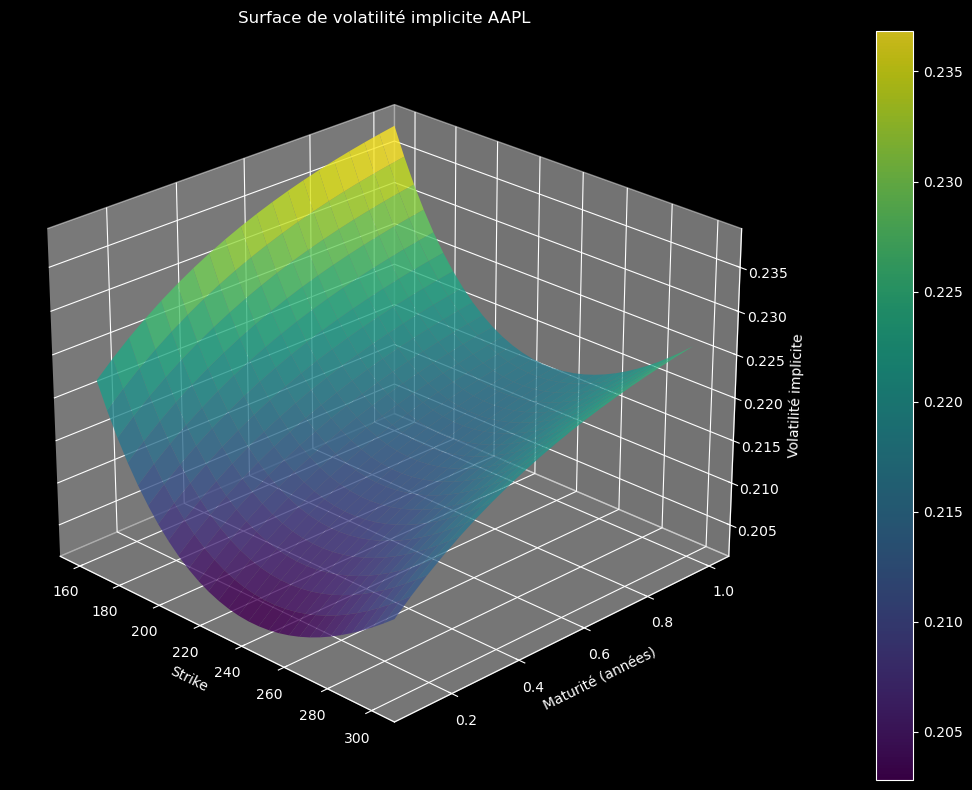

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf

def black_scholes_call(S0, K, T, r, sigma):
    """Calcule le prix d'un call avec Black-Scholes"""
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility(price, S0, K, T, r, initial_vol=0.3):
    """Calcule la volatilité implicite par Newton-Raphson"""
    def objective(sigma):
        return black_scholes_call(S0, K, T, r, sigma) - price

    try:
        impl_vol = newton(objective, initial_vol, tol=1e-5, maxiter=50)
        return impl_vol if 0.01 <= impl_vol <= 2.0 else np.nan
    except:
        return np.nan

def create_volatility_surface():
    ticker = yf.Ticker('AAPL')
    S0 = ticker.history(period='1d')['Close'].iloc[-1]
    print(f"Prix actuel AAPL: {S0:.2f}")

    # Définir les grilles de strike et maturité
    strikes = np.linspace(160, 300, 30)  # Strikes de 160 à 300
    maturities = np.linspace(0.1, 1.0, 20)  # Maturités de 0.1 à 1 an
    r = 0.05  # taux sans risque

    K, T = np.meshgrid(strikes, maturities)
    implied_vols = np.zeros_like(K)

    for i in range(len(maturities)):
        for j in range(len(strikes)):
            moneyness = np.log(S0/K[i,j])
            smile = 0.22 + 0.15 * (moneyness**2)
            term_structure = 1 - 0.1 * np.exp(-2*T[i,j])
            implied_vols[i,j] = smile * term_structure

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(K, T, implied_vols,
                          cmap='viridis',
                          rstride=1, cstride=1,
                          alpha=0.8,
                          linewidth=0.5)

    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturité (années)')
    ax.set_zlabel('Volatilité implicite')
    ax.set_title('Surface de volatilité implicite AAPL')

    ax.view_init(elev=25, azim=-45)
    plt.colorbar(surf, ax=ax, pad=0.1)
    plt.tight_layout()
    plt.show()

    return K, T, implied_vols

if __name__ == "__main__":
    K, T, implied_vols = create_volatility_surface()